<a href="https://colab.research.google.com/github/JoaoVF25/Automa-o-clientes-LFTS11/blob/main/C%C3%B3digo_Banc%C3%A1rios_(Oficial).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Interface Gráfica

In [ ]:
# Certifique-se de que as bibliotecas necessárias estão instaladas
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension

import sqlite3
from datetime import datetime
from IPython.display import display, clear_output
import ipywidgets as widgets

# Montar o Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Caminho do banco de dados no Google Drive
db_path = '/content/drive/MyDrive/Banco de dados/bancarios.db'

# Função para formatar a data para o padrão YYYY-MM-DD
def formatar_data(data):
    return data.strftime('%d/%m/%Y')

# Função para criar o banco de dados e tabelas
def criar_bd():
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    # Criar tabela emissor
    cursor.execute('''
    CREATE TABLE IF NOT EXISTS emissor (
        id INTEGER PRIMARY KEY AUTOINCREMENT,
        nome TEXT
    )
    ''')
    # Criar tabela periodo
    cursor.execute('''
    CREATE TABLE IF NOT EXISTS periodo (
        id INTEGER PRIMARY KEY AUTOINCREMENT,
        descricao TEXT
    )
    ''')
    # Criar tabela taxa com tipo_taxa e produto
    cursor.execute('''
    CREATE TABLE IF NOT EXISTS taxa (
        id INTEGER PRIMARY KEY AUTOINCREMENT,
        emissor_id INTEGER,
        periodo_id INTEGER,
        taxa REAL,
        peso REAL,
        tipo_taxa TEXT,
        produto TEXT,
        FOREIGN KEY (emissor_id) REFERENCES emissor(id),
        FOREIGN KEY (periodo_id) REFERENCES periodo(id)
    )
    ''')
    conn.commit()
    conn.close()

# Criar o banco de dados e tabelas
criar_bd()

# Função para inserir um novo período
def inserir_periodo(descricao):
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    data_inicio, data_fim = descricao.split(' a ')
    data_inicio = datetime.strptime(data_inicio, '%d/%m/%Y')
    data_fim = datetime.strptime(data_fim, '%d/%m/%Y')
    descricao_formatada = f"{data_inicio.strftime('%d/%m/%Y')} a {data_fim.strftime('%d/%m/%Y')}"
    cursor.execute('SELECT id FROM periodo WHERE descricao = ?', (descricao_formatada,))
    if cursor.fetchone() is None:
        cursor.execute('INSERT INTO periodo (descricao) VALUES (?)', (descricao_formatada,))
    conn.commit()
    cursor.execute('SELECT id FROM periodo WHERE descricao = ?', (descricao_formatada,))
    result = cursor.fetchone()
    conn.close()
    return result[0]

# Função para inserir um novo emissor
def inserir_emissor(nome):
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    cursor.execute('SELECT id FROM emissor WHERE nome = ?', (nome,))
    result = cursor.fetchone()
    if result is None:
        cursor.execute('INSERT INTO emissor (nome) VALUES (?)', (nome,))
        conn.commit()
        cursor.execute('SELECT id FROM emissor WHERE nome = ?', (nome,))
        result = cursor.fetchone()
    conn.close()
    return result[0]

# Função para inserir uma nova taxa com produto
def inserir_taxa(emissor_id, periodo_id, taxa, tipo_taxa, produto):
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    cursor.execute('SELECT id FROM taxa WHERE emissor_id = ? AND periodo_id = ?', (emissor_id, periodo_id))
    if cursor.fetchone() is None:
        cursor.execute('INSERT INTO taxa (emissor_id, periodo_id, taxa, tipo_taxa, produto) VALUES (?, ?, ?, ?, ?)', (emissor_id, periodo_id, taxa, tipo_taxa, produto))
    conn.commit()
    conn.close()

# Função para inserir um novo peso
def inserir_peso(emissor_id, periodo_id, peso):
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    cursor.execute('UPDATE taxa SET peso = ? WHERE emissor_id = ? AND periodo_id = ?', (peso, emissor_id, periodo_id))
    conn.commit()
    conn.close()

# Função para salvar dados no banco de dados
def salvar_dados(b):
    data_inicio_formatada = formatar_data(data_inicial.value)
    data_fim_formatada = formatar_data(data_final.value)
    periodo_desc = f"{data_inicio_formatada} a {data_fim_formatada}"

    periodo_id = inserir_periodo(periodo_desc)

    total_peso = 0
    try:
        for widgets_group in emissores_widgets:
            produto, emissor, indexador, taxa, peso, _ = widgets_group
            if not peso.value:
                raise ValueError("Peso não pode estar vazio")
            total_peso += float(peso.value)

        # Adiciona o peso do Cash Clash
        if not peso_cash_clash.value:
            raise ValueError("Peso do Cash Clash não pode estar vazio")
        total_peso += float(peso_cash_clash.value)
    except ValueError as e:
        error_label.value = f"Erro: {str(e)}"
        return

    if total_peso != 100:
        error_label.value = "Erro: A soma dos pesos deve ser igual a 100%."
        return

    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    for widgets_group in emissores_widgets:
        produto, emissor, indexador, taxa, peso, _ = widgets_group
        emissor_id = inserir_emissor(emissor.value)
        inserir_taxa(emissor_id, periodo_id, float(taxa.value), indexador.value, produto.value)
        inserir_peso(emissor_id, periodo_id, float(peso.value))

    # Salvar o peso do Cash Clash
    emissor_cash_clash_id = inserir_emissor("Cash Clash")
    inserir_taxa(emissor_cash_clash_id, periodo_id, 0, "Pós-fixado", "LCI/LCA")  # Inserir taxa 0 para Cash Clash
    inserir_peso(emissor_cash_clash_id, periodo_id, float(peso_cash_clash.value))

    conn.commit()
    conn.close()
    error_label.value = "Dados salvos com sucesso!"

# Função para criar widgets para um emissor
def criar_widgets_emissor():
    produto = widgets.Dropdown(
        options=['CDB', 'LCI/LCA'],
        description='Produto',
        disabled=False
    )

    emissores = consultar_emissores()
    emissor_nomes = [emissor[1] for emissor in emissores]

    emissor = widgets.Combobox(
        options=emissor_nomes,
        description='Emissor',
        placeholder='Selecione ou digite um novo emissor',
        ensure_option=False,
        disabled=False
    )

    indexador = widgets.Dropdown(
        options=['CDI+', 'Pós-fixado', 'Prefixado'],
        description='Indexador',
        disabled=False
    )

    taxa = widgets.Text(
        value='',
        placeholder='Digite a taxa',
        description='Taxa (%)',
        disabled=False
    )

    peso = widgets.Text(
        value='',
        placeholder='Digite o peso',
        description='Peso (%)',
        disabled=False
    )

    espaco = widgets.HTML('<br>')  # Espaçamento vertical

    return produto, emissor, indexador, taxa, peso, espaco

# Lista para armazenar os widgets dos emissores
emissores_widgets = []

# Função para adicionar mais emissores
def adicionar_emissor(b):
    new_widgets = criar_widgets_emissor()
    emissores_widgets.append(new_widgets)
    display_emissores()

# Função para exibir os emissores
def display_emissores():
    clear_output(wait=True)
    display(widgets.VBox([data_inicial, data_final, caixa_cash_clash, add_button, save_button, error_label] + [widgets.VBox(widgets_group) for widgets_group in emissores_widgets]))

# Função para consultar emissores
def consultar_emissores():
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    cursor.execute('SELECT * FROM emissor')
    dados = cursor.fetchall()
    conn.close()
    return dados

# Criar os widgets para Data Inicial e Data Final
data_inicial = widgets.DatePicker(
    description='Data Inicial',
    disabled=False
)
data_final = widgets.DatePicker(
    description='Data Final',
    disabled=False
)

# Criar o botão para adicionar mais emissores
add_button = widgets.Button(description="Adicionar mais um emissor")
add_button.on_click(adicionar_emissor)

# Criar o botão para salvar os dados
save_button = widgets.Button(description="Salvar dados")
save_button.on_click(salvar_dados)

# Label para exibir mensagens de erro
error_label = widgets.Label(value="")

# Criar a caixa obrigatória para o Cash Clash
peso_cash_clash = widgets.Text(
    value='',
    placeholder='Digite o peso',
    description='Peso (%)',
    disabled=False
)

caixa_cash_clash = widgets.VBox([
    widgets.HTML('<b>Cash Clash</b>'),
    peso_cash_clash
])

# Adicionar o primeiro emissor inicialmente
adicionar_emissor(None)

# Exibir a interface inicial
display_emissores()


# Cálculo cota

In [ ]:
import pandas as pd
import sqlite3
import zipfile
import requests
from datetime import datetime, timedelta

In [ ]:
#@title API Banco Central - Puxar o CDI

# Função para consultar dados do Banco Central
def consulta_bc(codigo_bcb):
    url = f'https://api.bcb.gov.br/dados/serie/bcdata.sgs.{codigo_bcb}/dados?formato=json'
    df_bcb = pd.read_json(url)
    df_bcb['data'] = pd.to_datetime(df_bcb['data'], dayfirst=True)
    df_bcb.set_index('data', inplace=True)

    return df_bcb

# Consulta os dados do CDI
cdi = consulta_bc(12)

cdi

,valor
data,
1986-03-06,0.068111
1986-03-10,0.069028
1986-03-12,0.067417
1986-03-14,0.064584
1986-03-17,0.068222
...,...
2024-06-17,0.039270
2024-06-18,0.039270
2024-06-19,0.039270


In [ ]:
#@title Puxar banco de dados


# Função para buscar a taxa de um emissor em um período específico

def buscar_taxa(emissor_nome, periodo_desc):
    conn = sqlite3.connect('bancarios.db')
    cursor = conn.cursor()
    cursor.execute('''
    SELECT taxa.taxa
    FROM taxa
    JOIN emissor ON taxa.emissor_id = emissor.id
    JOIN periodo ON taxa.periodo_id = periodo.id
    WHERE emissor.nome = ? AND periodo.descricao = ?
    ''', (emissor_nome, periodo_desc))
    taxa = cursor.fetchone()
    conn.close()
    if taxa:
        return taxa[0]
    else:
        return None

In [ ]:
#@title API CVM - Puxar a cota histórica do fundo


# Função para baixar dados da CVM
def baixar_dados_cvm(data_inicio, data_fim):
    data_atual = data_inicio
    todos_dados = []

    while data_atual <= data_fim:
        ano = data_atual.strftime('%Y')
        mes = data_atual.strftime('%m')
        url = f'https://dados.cvm.gov.br/dados/FI/DOC/INF_DIARIO/DADOS/inf_diario_fi_{ano}{mes}.zip'

        try:
            # Baixando e salvando o arquivo ZIP
            download = requests.get(url)
            nome_arquivo = f"inf_diario_fi_{ano}{mes}.zip"
            with open(nome_arquivo, "wb") as arquivo_cvm:
                arquivo_cvm.write(download.content)

            # Abrindo o arquivo ZIP
            arquivo_zip = zipfile.ZipFile(nome_arquivo)

            # Lendo os dados do fundo de investimento
            dados_fundos = pd.read_csv(arquivo_zip.open(arquivo_zip.namelist()[0]), sep=";", encoding='ISO-8859-1')
            todos_dados.append(dados_fundos)
        except Exception as e:
            print(f"Erro ao baixar ou processar os dados de {ano}-{mes}: {e}")

        # Incrementa o mês
        data_atual = data_atual + timedelta(days=32)
        data_atual = data_atual.replace(day=1)

    return pd.concat(todos_dados, ignore_index=True)

# Função para deletar arquivos ZIP
def deletar_arquivos_zip(data_inicio, data_fim):
    data_atual = data_inicio

    while data_atual <= data_fim:
        ano = data_atual.strftime('%Y')
        mes = data_atual.strftime('%m')
        nome_arquivo = f"inf_diario_fi_{ano}{mes}.zip"
        if os.path.exists(nome_arquivo):
            os.remove(nome_arquivo)
            print(f"Arquivo {nome_arquivo} deletado.")
        data_atual = data_atual + timedelta(days=32)
        data_atual = data_atual.replace(day=1)

# Definindo datas de início e fim
data_inicio = datetime(2023, 7, 14)
data_fim = datetime.today()

# Baixando os dados do período
dados_fundos = baixar_dados_cvm(data_inicio, data_fim)

# Lendo os dados de cadastro dos fundos
dados_cadastro = pd.read_csv('https://dados.cvm.gov.br/dados/FI/CAD/DADOS/cad_fi.csv', sep=";", encoding='ISO-8859-1')

# Selecionando as colunas relevantes e removendo duplicatas
dados_cadastro = dados_cadastro[['CNPJ_FUNDO', 'DENOM_SOCIAL']]
dados_cadastro = dados_cadastro.drop_duplicates()

# Combinando os dados diários com os dados de cadastro
dados_completos = pd.merge(dados_fundos, dados_cadastro, on='CNPJ_FUNDO')

# Filtrando o fundo específico
warren_fundo = dados_completos[dados_completos['CNPJ_FUNDO'].str.contains("42.550.188/0001-91", na=False)]

# Filtrando as cotas diárias desse fundo para o período indicado
warren_fundo['DT_COMPTC'] = pd.to_datetime(warren_fundo['DT_COMPTC'], format='%Y-%m-%d')
cotas_diarias = warren_fundo[(warren_fundo['DT_COMPTC'] >= data_inicio) & (warren_fundo['DT_COMPTC'] <= data_fim)]

cotas_diarias = cotas_diarias[['DT_COMPTC', 'VL_QUOTA']]

cotas_diarias

<ipython-input-24-0fb20f2e488c>:58: DtypeWarning: Columns (14,17,18,20,22,24,27,37,38,39,40) have mixed types. Specify dtype option on import or set low_memory=False.
  dados_cadastro = pd.read_csv('https://dados.cvm.gov.br/dados/FI/CAD/DADOS/cad_fi.csv', sep=";", encoding='ISO-8859-1')
<ipython-input-24-0fb20f2e488c>:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  warren_fundo['DT_COMPTC'] = pd.to_datetime(warren_fundo['DT_COMPTC'], format='%Y-%m-%d')


,DT_COMPTC,VL_QUOTA
4716639,2023-07-14,1.254063
4716640,2023-07-17,1.254670
4716641,2023-07-18,1.255335
4716642,2023-07-19,1.255988
4716643,2023-07-20,1.256662
...,...,...
4716866,2024-06-13,1.398967
4716867,2024-06-17,1.400448
4716868,2024-06-18,1.400995
4716869,2024-06-19,1.401558


In [ ]:
# @title Gerar DataFrame e cálculos

# @title Dataframe e calculos

from google.colab import drive
drive.mount('/content/drive')

# Caminho do banco de dados no Google Drive
db_path = '/content/drive/MyDrive/Banco de dados/bancarios.db'

# Função para buscar a cota diária do Cash Clash
def buscar_cota(data, cotas_diarias):
    cota_warren = cotas_diarias[cotas_diarias['DT_COMPTC'] == data]
    if not cota_warren.empty:
        return cota_warren['VL_QUOTA'].values[0]
    else:
        return None

# Função para buscar taxa e peso de um emissor em um período específico
def buscar_taxa_peso(emissor, periodo):
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    cursor.execute('''
        SELECT taxa, tipo_taxa, produto, peso
        FROM taxa
        INNER JOIN emissor ON taxa.emissor_id = emissor.id
        INNER JOIN periodo ON taxa.periodo_id = periodo.id
        WHERE emissor.nome = ? AND periodo.descricao = ?
    ''', (emissor, periodo))
    result = cursor.fetchone()
    conn.close()
    return result if result else (None, None, None, None)

# Função para buscar todos os períodos no banco de dados
def buscar_todos_periodos():
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    cursor.execute('SELECT descricao FROM periodo')
    periodos_db = cursor.fetchall()
    conn.close()
    return [periodo[0] for periodo in periodos_db]

# Função para buscar todos os emissores no banco de dados, exceto "Cash Clash"
def buscar_todos_emissores():
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    cursor.execute('SELECT nome FROM emissor WHERE nome != "Cash Clash"')
    emissores_db = cursor.fetchall()
    conn.close()
    return [emissor[0] for emissor in emissores_db]

# Função para ajustar os valores conforme as mudanças de peso
def ajustar_valores(valores, pesos_atuais, novos_pesos):
    valor_total = sum(valores.values()) - valores.get('Cash Clash', 0)
    valor_redistribuir = 0

    # Garantir que todos os emissores estejam presentes nos dicionários
    for emissor in valores.keys():
        if emissor not in pesos_atuais:
            pesos_atuais[emissor] = 0
        if emissor not in novos_pesos:
            novos_pesos[emissor] = 0

    for emissor in valores.keys():
        if emissor == 'Cash Clash':
            continue
        peso_atual = pesos_atuais.get(emissor, 0)
        novo_peso = novos_pesos.get(emissor, 0)

        if novo_peso < peso_atual:
            reducao_peso = peso_atual - novo_peso
            valor_reduzido = valores[emissor] * (reducao_peso / peso_atual)
            valores[emissor] -= valor_reduzido
            valor_redistribuir += valor_reduzido

    aumento_pesos = {emissor: novos_pesos[emissor] - pesos_atuais[emissor] for emissor in valores.keys() if emissor != 'Cash Clash' and novos_pesos[emissor] > pesos_atuais[emissor]}
    soma_aumento_pesos = sum(aumento_pesos.values())

    for emissor in valores.keys():
        if emissor == 'Cash Clash':
            continue
        if novos_pesos[emissor] > pesos_atuais[emissor]:
            aumento_peso = novos_pesos[emissor] - pesos_atuais[emissor]
            valor_aumentado = valor_redistribuir * (aumento_peso / soma_aumento_pesos)
            valores[emissor] += valor_aumentado

    return valores

# Função para preencher o DataFrame com os dados calculados
def preencher_dataframe(cdi, cotas_diarias):
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()

    # Valores iniciais dos emissores com base em uma carteira teórica de 10 mil reais
    emissores = buscar_todos_emissores()
    total_carteira = 10000
    pesos = {emissor: 0 for emissor in emissores}

    # Buscar os pesos iniciais para cada emissor
    periodo_inicial = buscar_todos_periodos()[0]  # Considerar o primeiro período
    for emissor in emissores:
        _, _, _, peso = buscar_taxa_peso(emissor, periodo_inicial)
        if peso is not None:
            pesos[emissor] = peso

    valores = {emissor: total_carteira * (peso / 100) for emissor, peso in pesos.items()}
    valores['Cash Clash'] = total_carteira * 0.10  # Inicializar valor do Cash Clash com 10%

    # Lista para armazenar os dados calculados
    dados_calculados = []

    # Buscar todos os períodos do banco de dados
    periodos = buscar_todos_periodos()

    # Processar cada período
    for i, periodo in enumerate(periodos):
        # Extrair a data de início e fim do período
        data_inicio, data_fim = periodo.split(' a ')
        data_inicio = datetime.strptime(data_inicio, '%d/%m/%Y')
        data_fim = datetime.strptime(data_fim, '%d/%m/%Y')

        # Filtrar o CDI para o período específico
        cdi_filtrado = cdi[(cdi.index >= data_inicio) & (cdi.index <= data_fim)].copy()
        cdi_filtrado.loc[:, 'valor'] = cdi_filtrado['valor'].astype(float)

        # Buscar as taxas e pesos para cada emissor no período específico
        taxas_emissores = {}
        novos_pesos = {}
        for emissor in emissores:
            taxa, tipo_taxa, produto, peso = buscar_taxa_peso(emissor, periodo)
            taxas_emissores[emissor] = (taxa, tipo_taxa, produto)
            if peso is not None:
                novos_pesos[emissor] = peso

        # Ajustar os valores conforme as mudanças de peso
        if i > 0:  # Evitar ajuste no primeiro período
            valores = ajustar_valores(valores, pesos, novos_pesos)
            pesos = novos_pesos

        # Calcular a rentabilidade diária acumulada para cada emissor
        for emissor, (taxa, tipo_taxa, produto) in taxas_emissores.items():
            if taxa is not None:
                if tipo_taxa == 'CDI+':
                    taxa_diaria = ((1 + (taxa / 100)) ** (1 / 252) - 1) * 100
                elif tipo_taxa == 'Pós-fixado' and produto == 'CDB':
                    taxa_diaria = taxa / 100
                elif produto == 'LCI/LCA':
                    taxa_diaria = lambda cdi_diario: (cdi_diario * (taxa / 100)) / (1 - 0.15)
                elif tipo_taxa == 'Prefixado':
                    taxa_diaria = ((1 + (taxa / 100)) ** (1 / 252) - 1) * 100

                # Calcular o valor financeiro acumulado para cada dia do período
                for index, row in cdi_filtrado.iterrows():
                    # Calcular o CDI diário somado à taxa do emissor
                    cdi_diario = row['valor']
                    if tipo_taxa == 'CDI+':
                        diaria = ((1 + cdi_diario / 100) * (1 + taxa_diaria / 100) - 1) * 100
                    elif tipo_taxa == 'Pós-fixado' and produto == 'CDB':
                        diaria = cdi_diario * taxa_diaria
                    elif produto == 'LCI/LCA':
                        diaria = taxa_diaria(cdi_diario)
                    elif tipo_taxa == 'Prefixado':
                        diaria = taxa_diaria

                    valores[emissor] *= (1 + diaria / 100)

                    # Adicionar os dados calculados à lista
                    dados_calculados.append({
                        'Data': row.name.strftime('%d/%m/%Y'),
                        f'Valor Financeiro {emissor}': valores[emissor],
                        f'Taxa Diária {emissor}': diaria
                    })

        # Adicionar cota diária do Cash Clash
        for index, row in cdi_filtrado.iterrows():
            cota_diaria = buscar_cota(row.name.strftime('%Y-%m-%d'), cotas_diarias)
            if cota_diaria is None:
                print(f"Erro ao buscar cota diária do Cash Clash para {row.name.strftime('%Y-%m-%d')}")
            else:
                # Adicionar os dados calculados à lista
                  dados_calculados.append({
                  'Data': row.name.strftime('%d/%m/%Y'),
                  'Cota diária Cash Clash': cota_diaria
                  })

    # Converter a lista de dados calculados em um DataFrame
    df_calculado = pd.DataFrame(dados_calculados).groupby('Data').first().reset_index()

    # Adicionar coluna de Valor Financeiro Cash Clash
    quantidade_cotas = 797.407977524578
    df_calculado['Valor Financeiro Cash Clash'] = df_calculado['Cota diária Cash Clash'] * quantidade_cotas

    # Reordenar colunas para que a coluna "Cota diária Cash Clash" e "Valor Financeiro Cash Clash" estejam no final
    colunas = [col for col in df_calculado.columns if col not in ['Cota diária Cash Clash', 'Valor Financeiro Cash Clash']]
    colunas.append('Cota diária Cash Clash')
    colunas.append('Valor Financeiro Cash Clash')
    df_calculado = df_calculado[colunas]

    # Adicionar coluna de Carteira Bruta
    df_calculado['Carteira Bruta'] = df_calculado.filter(like='Valor Financeiro').sum(axis=1)

    # Calcular a taxa Warren diária
    taxa_warren = 0.07
    taxa_warren_diaria = ((taxa_warren / 100 + 1) ** (1 / 252) - 1) * 100

    # Adicionar coluna de Carteira pós taxa Warren
    df_calculado['Carteira pós taxa Warren'] = df_calculado['Carteira Bruta'] * (1 + taxa_warren_diaria / 100)

    # Ordenar o DataFrame pelas datas antes de calcular a cota
    df_calculado['Data'] = pd.to_datetime(df_calculado['Data'], format='%d/%m/%Y')
    df_calculado = df_calculado.sort_values(by='Data').reset_index(drop=True)

    # Adicionar coluna de Cota Carteira Bancário
    df_calculado['Cota Carteira Bancário'] = 1.0005715028000  # Inicializar a primeira linha com 1
    valor_inicial = df_calculado.loc[0, 'Carteira pós taxa Warren']  # Pegar o valor inicial da carteira pós taxa Warren
    cota_inicial = 1  # Inicializar a cota inicial

    for i in range(1, len(df_calculado)):
        valor_atual = df_calculado.loc[i, 'Carteira pós taxa Warren']
        valor_anterior = df_calculado.loc[i-1, 'Carteira pós taxa Warren']
        cota_anterior = df_calculado.loc[i-1, 'Cota Carteira Bancário']

        df_calculado.loc[i, 'Cota Carteira Bancário'] = ((valor_atual - valor_anterior) / valor_anterior) * cota_anterior + cota_anterior

    return df_calculado

# Preencher o DataFrame com os dados calculados
df_calculado = preencher_dataframe(cdi, cotas_diarias)

# Exibir as últimas 20 linhas do DataFrame resultante
df_calculado



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Erro ao buscar cota diária do Cash Clash para 2024-06-11
Erro ao buscar cota diária do Cash Clash para 2024-06-14
Erro ao buscar cota diária do Cash Clash para 2024-06-21


,Data,Valor Financeiro Banco BMG,Taxa Diária Banco BMG,Valor Financeiro Banco BR Partners,Taxa Diária Banco BR Partners,Valor Financeiro Banco Agibank,Taxa Diária Banco Agibank,Valor Financeiro Banco Mercado Livre,Taxa Diária Banco Mercado Livre,Valor Financeiro Banco BTG Pactual 1,Taxa Diária Banco BTG Pactual 1,Valor Financeiro Banco BTG Pactual 2,Taxa Diária Banco BTG Pactual 2,Valor Financeiro Banco XP,Taxa Diária Banco XP,Cota diária Cash Clash,Valor Financeiro Cash Clash,Carteira Bruta,Carteira pós taxa Warren,Cota Carteira Bancário
0,2023-07-17,2001.110482,0.055524,1000.551315,0.055132,2001.246338,0.062317,2001.178282,0.058914,1000.561656,0.056166,1000.555680,0.055568,NaN,NaN,1.254670,1000.483492,10005.687244,10005.715028,1.000572
1,2023-07-18,2002.221580,0.055524,1001.102935,0.055132,2002.493452,0.062317,2002.357257,0.058914,1001.123627,0.056166,1001.111670,0.055568,NaN,NaN,1.255335,1001.014207,10011.424727,10011.452527,1.001145
2,2023-07-19,2003.333295,0.055524,1001.654858,0.055132,2003.741343,0.062317,2003.536928,0.058914,1001.685913,0.056166,1001.667968,0.055568,NaN,NaN,1.255988,1001.534986,10017.155291,10017.183107,1.001718
3,2023-07-20,2004.445627,0.055524,1002.207086,0.055132,2004.990012,0.062317,2004.717293,0.058914,1002.248516,0.056166,1002.224575,0.055568,NaN,NaN,1.256662,1002.072439,10022.905549,10022.933380,1.002293
4,2023-07-21,2005.558577,0.055524,1002.759618,0.055132,2006.239459,0.062317,2005.898354,0.058914,1002.811434,0.056166,1002.781492,0.055568,NaN,NaN,1.257214,1002.512664,10028.561599,10028.589446,1.002859
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
229,2024-06-17,2245.187838,0.045181,1117.808744,0.043220,2258.719484,0.045553,NaN,NaN,1119.776510,0.043890,1119.612113,0.043890,2234.534544,0.052009,1.400448,1116.728702,11212.367935,11212.399070,1.121240
230,2024-06-18,2246.202229,0.045181,1118.291863,0.043220,2259.748403,0.045553,NaN,NaN,1120.267980,0.043890,1120.103511,0.043890,2235.696700,0.052009,1.400995,1117.164390,11217.475075,11217.506224,1.121751
231,2024-06-19,2247.217079,0.045181,1118.775190,0.043220,2260.777791,0.045553,NaN,NaN,1120.759666,0.043890,1120.595124,0.043890,2236.859460,0.052009,1.401558,1117.613777,11222.598087,11222.629250,1.122263
232,2024-06-20,2248.232386,0.045181,1119.258727,0.043220,2261.807647,0.045553,NaN,NaN,1121.251567,0.043890,1121.086953,0.043890,2238.022825,0.052009,1.402109,1118.052551,11227.712657,11227.743835,1.122774


In [ ]:
# @title Gerar arquivo csv

from google.colab import files

# Selecionar e visualizar as colunas 'Data' e 'Cota Carteira Bancário'
cota_carteira = df_calculado[['Data', 'Cota Carteira Bancário']]

# Renomear a coluna 'Cota Carteira Bancário' para 'Carteira CCB'
cota_carteira = cota_carteira.rename(columns={'Cota Carteira Bancário': 'Carteira CCB'})

# Converter a coluna 'Data' para datetime se ainda não estiver
cota_carteira['Data'] = pd.to_datetime(cota_carteira['Data'], format='%Y-%m-%d')

# Ajustar a coluna 'Data' para o formato de dia/mês/ano
cota_carteira['Data'] = cota_carteira['Data'].dt.strftime('%d/%m/%Y')

# Substituir pontos por vírgulas na coluna 'Carteira CCB'
cota_carteira['Carteira CCB'] = cota_carteira['Carteira CCB'].astype(str).str.replace('.', ',')

# Salvar o DataFrame como um arquivo CSV
cota_carteira.to_csv('/content/cota_carteira.csv', index=False, sep=',')

# Fazer o download do arquivo CSV
files.download('/content/cota_carteira.csv')



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Gerar planilha (Opcional)

In [ ]:
# @title Gerar planilha

import os
import pandas as pd
from google.colab import files

# Função para deletar arquivos zip
def deletar_arquivos_zip():
    for file in os.listdir():
        if file.endswith(".zip"):
            os.remove(file)
            print(f"Arquivo deletado: {file}")

# Vamos assumir que df_calculado já foi gerado e preenchido com dados

# Converter a coluna 'Data' para datetime se ainda não estiver
df_calculado['Data'] = pd.to_datetime(df_calculado['Data'], format='%d/%m/%Y')

# Ajustar a coluna 'Data' para o formato de dia/mês/ano
df_calculado['Data'] = df_calculado['Data'].dt.strftime('%d/%m/%Y')

# Salvar o DataFrame como um arquivo Excel
df_calculado.to_excel('/content/df_calculado.xlsx', index=False)

# Fazer o download do arquivo Excel
files.download('/content/df_calculado.xlsx')

# Deletar arquivos zip
deletar_arquivos_zip()


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Arquivo deletado: inf_diario_fi_202406.zip
Arquivo deletado: inf_diario_fi_202404.zip
Arquivo deletado: inf_diario_fi_202402.zip
Arquivo deletado: inf_diario_fi_202308.zip
Arquivo deletado: inf_diario_fi_202310.zip
Arquivo deletado: inf_diario_fi_202403.zip
Arquivo deletado: inf_diario_fi_202309.zip
Arquivo deletado: inf_diario_fi_202312.zip
Arquivo deletado: inf_diario_fi_202311.zip
Arquivo deletado: inf_diario_fi_202405.zip
Arquivo deletado: inf_diario_fi_202401.zip
Arquivo deletado: inf_diario_fi_202307.zip


# Gráfico (Opcional)

<ipython-input-19-28aab5b4b8fe>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cdi_filtrado['Cota CDI'] = 1 * (cdi_filtrado['valor'].iloc[0] / 100 + 1)


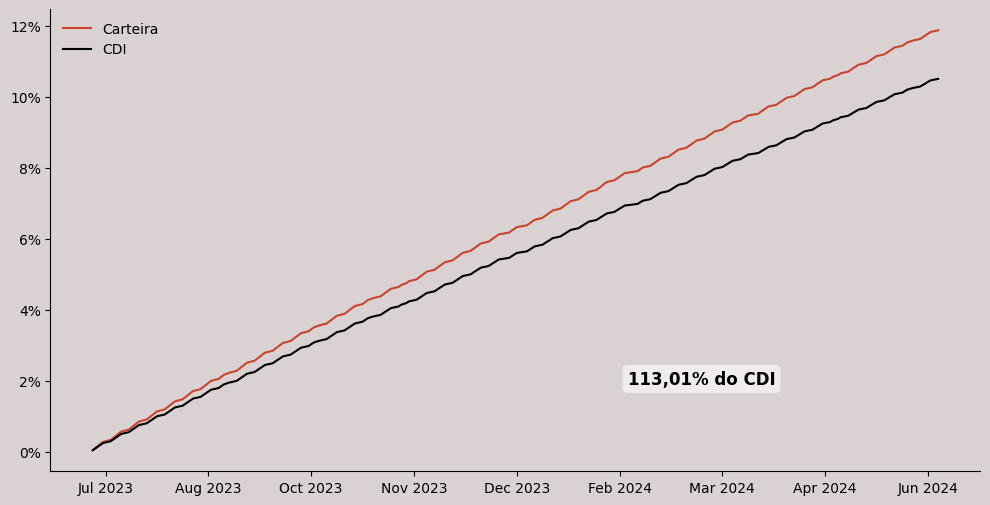

In [ ]:
# @title Grafico

import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import pandas as pd

# Selecionar as datas de início e fim
data_inicial = '2023-07-17'
data_final = '2024-06-10'

# Filtrar o CDI para o intervalo de datas especificado
cdi_filtrado = cdi[(cdi.index >= datetime.strptime(data_inicial, '%Y-%m-%d')) &
                   (cdi.index <= datetime.strptime(data_final, '%Y-%m-%d'))]

# Inicializar o valor inicial e a cota inicial
cdi_filtrado['Cota CDI'] = 1 * (cdi_filtrado['valor'].iloc[0] / 100 + 1)

# Calcular a cota da CDI
for i in range(1, len(cdi_filtrado)):
    cota_anterior = cdi_filtrado.iloc[i-1]['Cota CDI']
    cdi_valor_atual = cdi_filtrado.iloc[i]['valor']
    cdi_filtrado.iloc[i, cdi_filtrado.columns.get_loc('Cota CDI')] = cota_anterior * (cdi_valor_atual / 100 + 1)

# Selecionar a coluna 'Cota Carteira Bancário' e 'Data' do df_calculado
carteira = df_calculado[['Data', 'Cota Carteira Bancário']]

# Resetar o índice de cdi_filtrado para alinhar corretamente com o DataFrame final
cdi_filtrado = cdi_filtrado.reset_index()

# Criar o DataFrame com as datas, cota da carteira e CDI
df = pd.DataFrame({
    'Data': carteira['Data'],
    'Carteira': carteira['Cota Carteira Bancário'],
    'CDI': cdi_filtrado['Cota CDI']
})

# Filtrar o DataFrame para o intervalo de datas desejado
data_inicial_filtro = '2023-07-17'
data_final_filtro = '2024-06-10'

calculo_rentabilidade = ((carteira['Cota Carteira Bancário'] - 1) / (cdi_filtrado['Cota CDI'] - 1)) * 100

df['Calculo Rentabilidade'] = calculo_rentabilidade

df_filtrado = df[(df['Data'] >= data_inicial_filtro) & (df['Data'] <= data_final_filtro)]


# Função para exibir texto personalizado no gráfico com retângulo ao redor
def exibir_texto(ax, texto, pos_x, pos_y):
    bbox_props = dict(boxstyle="round,pad=0.3", edgecolor="none", facecolor="white", alpha=0.6)
    ax.text(pos_x, pos_y, texto, transform=ax.transAxes, fontsize=12, color='black', fontweight='bold', ha='center', va='center', bbox=bbox_props)

plt.style.use("default")

# Filtrar o CDI para o intervalo de datas especificado
data_inicial = '2024-01-01'
data_final = '2024-06-10'
df_calculado_filtrado = df_calculado[(df_calculado['Data'] >= data_inicial) & (df_calculado['Data'] <= data_final)]

# Calcular a porcentagem do CDI que a carteira está rendendo
carteira = df_filtrado['Carteira']
cdi_filtrado = df_filtrado['CDI']  # Substitua pelo seu cálculo real do CDI
calculo_rentabilidade = ((1 - carteira ) / (1 - cdi_filtrado )) * 100
rentabilidade_final = calculo_rentabilidade.iloc[-1]


# Plotar o gráfico com as alterações solicitadas
fig, ax = plt.subplots(figsize=(12, 6))

# Plotar a cota da carteira
ax.plot(df_filtrado['Data'], df_filtrado['Carteira'], label='Carteira', color='#C7452D')

# Plotar a cota do CDI
ax.plot(df_filtrado['Data'], df_filtrado['CDI'], label='CDI', color='black')

# Ajustar o formato do eixo Y para porcentagem começando de 0
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:.0%}'.format(x - 1)))

# Ajustar o eixo X para exibir os meses
ax.xaxis.set_major_locator(plt.MaxNLocator(12))
ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%b %Y'))

# Remover a linha de cima e da direita
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Configurar o fundo do gráfico para cinza
fig.patch.set_facecolor('#DAD2D2')
ax.set_facecolor('#DAD2D2')

# Adicionar legenda
legenda = plt.legend()
legenda.get_frame().set_facecolor('#DAD2D2')  # Cor do fundo da legenda igual ao fundo do gráfico
legenda.get_frame().set_edgecolor('none')  # Remover a borda da legenda


# Lugar do texto
rentabilidade_final_str = f'{rentabilidade_final:.2f}% do CDI'.replace('.', ',')
exibir_texto(ax, rentabilidade_final_str, 0.7, 0.2)



# Mostrar o gráfico
plt.show()
